In [1]:
import re
import os
import pandas as pd


from str2graph import create_graph,draw_graph
from alignment import align_graphs_on_AMR_splits
from animacyParser import parse_animacy_runner



c:\Users\mcg19\miniconda3\envs\UMR\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


   # Final Project
   This goal of this project is to disambiguate semantic roles in AMR that have multiple mappings in UMR (1:2,3). We have a dataest consisting of 5 parallel graphs.
   1. Lindsay
   2. Philippines Landslide
   3. Putin
   4. Edmund Pope
   5. Pear Story

## 1. Data Manipulation

### A. Get Files

In [6]:
# put all files in dicts
umr_files = {}
amr_files = {}

umr_path = os.getcwd() + '/raw_data\\UMR-data-english'
amr_path = os.getcwd() + '/raw_data\\AMR-data-english'

for f in os.listdir(umr_path):
    file1 = open(umr_path + '/' + f, 'r')
    umr_files[f] = file1.read()

for f in os.listdir(amr_path):
    file1 = open(amr_path + '/' + f, 'r')
    amr_files[f] = file1.read()

#Do not have all of the UMR annotations for the Putin document, so just grab everything before this sentence id from AMR
amr_files["putin_ENG_0152_2000_1208-AMR.txt"] = amr_files["putin_ENG_0152_2000_1208-AMR.txt"].split("::id NW_PRI_ENG_0152_2000_1208.13")[0]



In [7]:
#create file mappings
#Change key-names to the mapping above, allows for easier comparison
amr_files[1] = amr_files.pop('lindsay-AMR.txt')
amr_files[2] = amr_files.pop('lorpt-024_Phillipines_landslide_AMR.txt')
amr_files[3] = amr_files.pop('putin_ENG_0152_2000_1208-AMR.txt')
amr_files[4] = amr_files.pop('edmund_pope-AMR.txt')
amr_files[5] = amr_files.pop('pear-AMR__of__english-umr-0004.txt')

umr_files[1] = umr_files.pop('lindsay-umr.txt')
umr_files[2] = umr_files.pop('Lorelei_lorpt-024_Philippines_Landslide_2023-release.txt')
umr_files[3] = umr_files.pop('lorelei_lorpt-151_putin_2023-release.txt')
umr_files[4] = umr_files.pop('lorelei_lorpt-152_edmundpope_2023-release.txt')
umr_files[5] = umr_files.pop('Pear_Story_2023-release.txt')

file_map = {1:"Lindsay",2: "Landslide", 3:"Putin",4:"Edmund Pope", 5:"Pear Story"}

### B.  UMR and AMR sentence extraction, get number of sentences in each file

In [9]:
print("UMR")
umr_sents = {} #extracts string version of umr graph

umr_count = 0
for f in umr_files:
    umr_sents[f] = re.findall(r'(?<=sentence level graph:\n)\([^#]*(?=\n\n#)', umr_files[f])
    print(file_map[f],"Graphs extracted",len(umr_sents[f]))
    umr_count = umr_count + len(umr_sents[f])

print(umr_count)
    

all_sentences = []
all_sentences_AMR = {}
print('\n' + "AMR")
amr_sents = {}
for f in amr_files:
    sentences = re.findall(r'(?<=# ::snt\s).+?(?=\n)',amr_files[f]) #first look
    if not sentences:
        sentences = re.findall(r'(?<=:: snt)[^\n:]*(?=\n)',amr_files[f])#second look
        sentences = [re.sub(r'^\d+\s*', '', element) for element in sentences]
    count = len(sentences)
    all_sentences_AMR[f] = sentences
    all_sentences.extend(sentences)

   
    print(sentences[0])
    amr_sents[f] = re.findall(r'(?<=[\n])\([^#]*(?=\n|)', amr_files[f])#extract the graphs

    print(file_map[f],"|",len(amr_sents[f]))
    print(file_map[f],"sentences extracted",count)

print(len(all_sentences))


UMR
Lindsay Graphs extracted 2
Landslide Graphs extracted 28
Putin Graphs extracted 12
Edmund Pope Graphs extracted 9
Pear Story Graphs extracted 141
192

AMR
Lindsay left in order to eat lunch .
Lindsay | 2
Lindsay sentences extracted 2
200 dead, 1,500 feared missing in Philippines landslide
Landslide | 28
Landslide sentences extracted 28
The United States is hoping that Russia's President Vladimir Putin will follow the advice of his special commission and pardon Edmund Pope.
Putin | 12
Putin sentences extracted 12
Edmund Pope tasted freedom today for the first time in more than eight months.
Edmund Pope | 9
Edmund Pope sentences extracted 9
Okay .
Pear Story | 141
Pear Story sentences extracted 141
192


### C.  Turn Files into Graphs

In [12]:
#using the str2graph.create_graph() function
umr_graphs = {}
for file in umr_sents.keys():
    umr_graphs[file] = []
    for sent in umr_sents[file]:
          umr_graphs[file].append(create_graph(sent))

amr_graphs = {}
for file in amr_sents.keys():
    amr_graphs[file] = []
    for sent in amr_sents[file]:
        amr_graphs[file].append(create_graph(sent))



#### 1. UMR example

In a televised address to the nation, President Gloria Arroyo said rescue teams were rushing to the area from "air, land and sea" to cope with the catastrophe.
(s / say-01
      :ARG0 (p / person :wiki "Gloria_Macapagal_Arroyo" :name (n / name :op1 "Gloria" :op2 "Arroyo")
            :ARG0-of (h / have-org-role-91
                  :ARG2 (p2 / president)))
      :ARG1 (r / rush-01
            :ARG0 (c / cope-01
                  :ARG0 (t / team
                        :mod (r2 / rescue-01))
                  :ARG1 (c2 / catastrophe))
            :ARG1 t
            :ARG2 (a / area)
            :source (a2 / and
                  :op1 (a3 / air)
                  :op2 (l / land)
                  :op3 (s2 / sea)))
      :time (a4 / address-03
            :ARG0 p
            :ARG1 (n2 / nation)
            :ARG1-of (t2 / televise-01)))


(s9s / say-01 
    :ARG0 (s9p / person :wiki "Gloria_Macapagal_Arroyo" 
        :name (s9n / name :op1 "Gloria" :op2 "Arroyo") 
        :ARG1-of (s9h / 

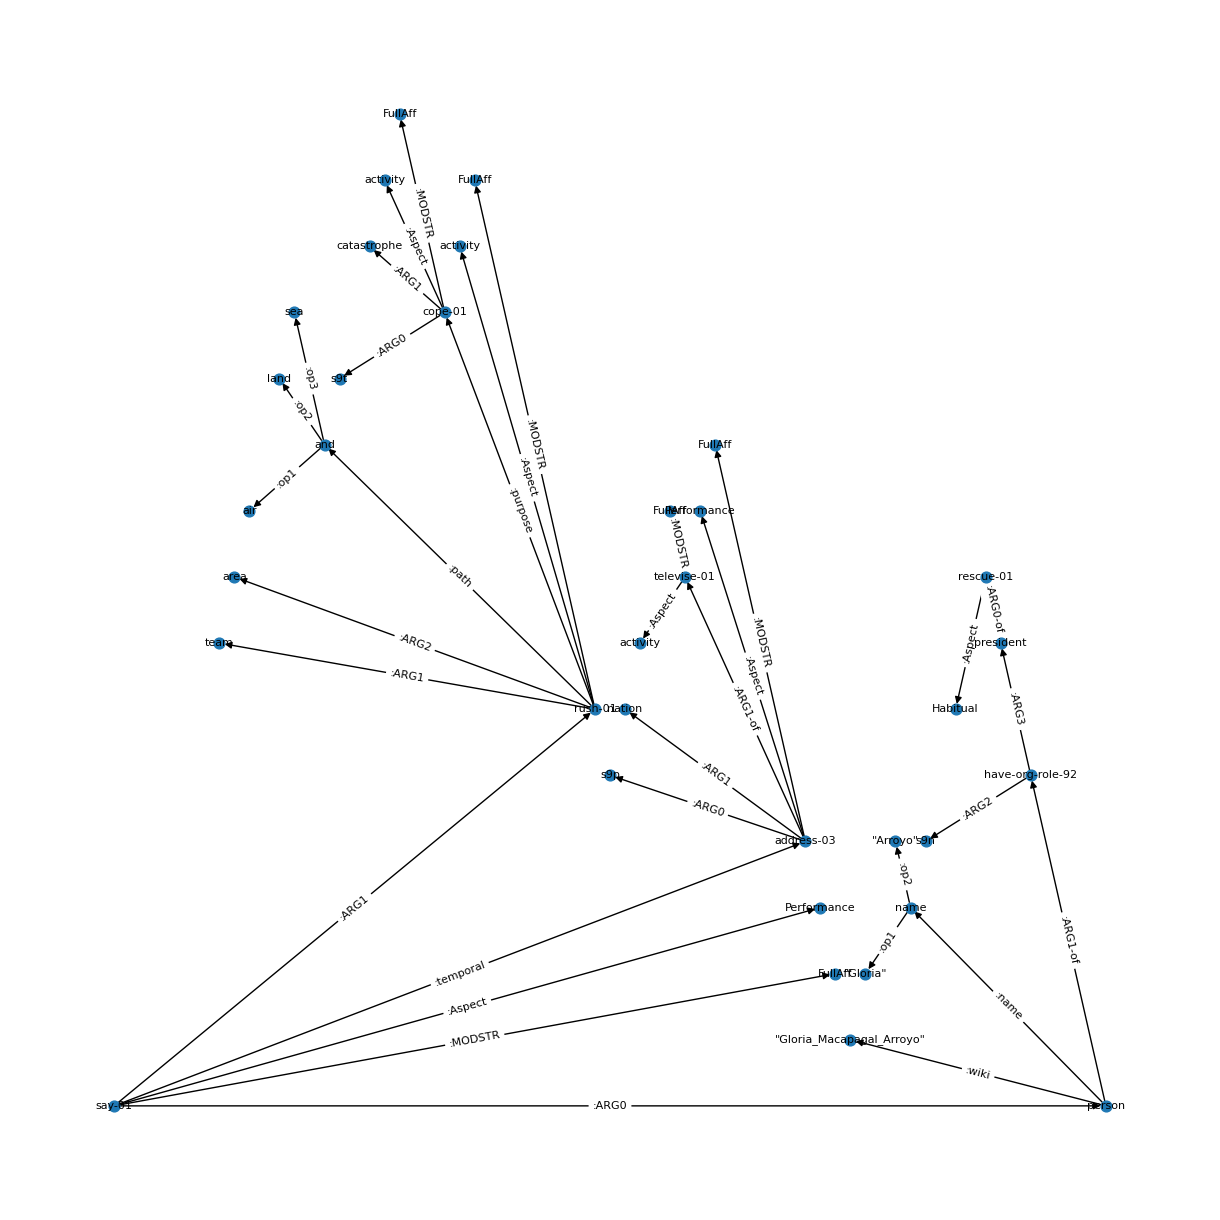

In [15]:
print(all_sentences_AMR[2][8])
print(amr_sents[2][8])
print(umr_sents[2][8])
draw_graph(umr_graphs[2][8])

#### 2. AMR Example

(s / show-01
      :ARG0 (f / footage
            :topic (v / village
                  :ARG1-of (d / devastate-01))
            :ord (o / ordinal-entity :value 1))
      :ARG1 (m / mud
            :quant (s2 / sea)
            :ARG0-of (c / cover-01
                  :ARG1 (t / thing
                        :mod (f2 / farmland)
                        :location (v2 / valley
                              :ARG1-of (g / green-02))
                        :mod (l / lush)))))




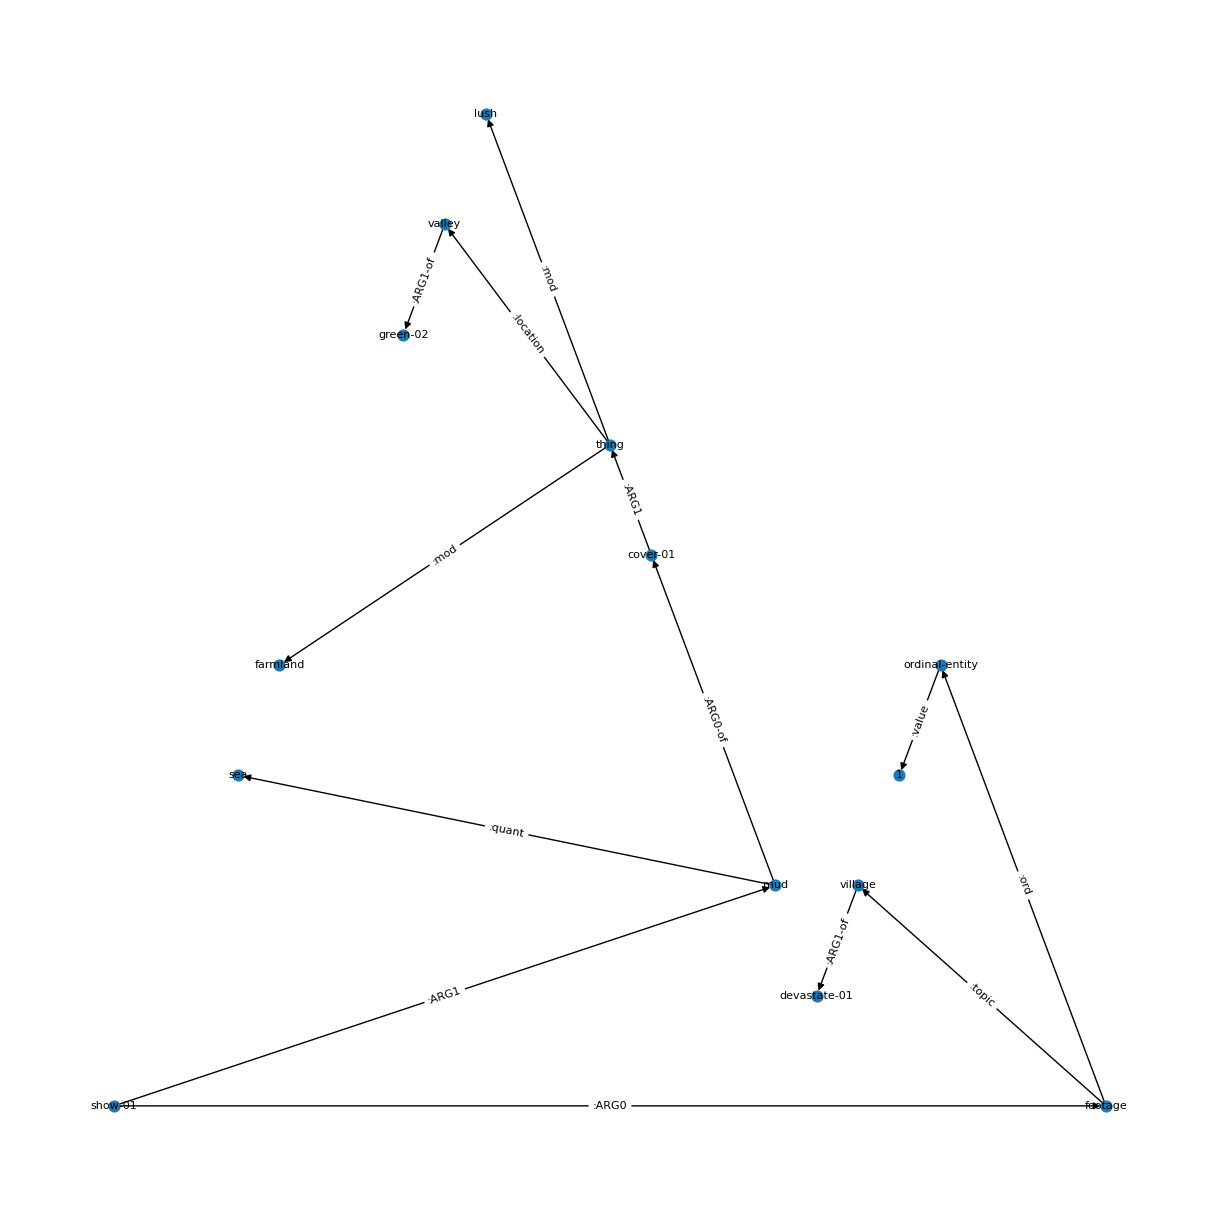

In [10]:

print(amr_sents[2][5])
draw_graph(amr_graphs[2][5])


## 2.  Split Roles


The roles in green
<iframe src="https://drive.google.com/file/d/1iQhPIp0NwKRSu4ZUXIgIkMUF9EHHlIiQ/preview" width="640" height="480" allow="autoplay"></iframe>

### A. Split Role Definitions

In [7]:
amr_roles= {":mod",
            ":cause",
            ":part", 
            ":consist-of",
            ":source",
            ":destination",
            ":condition"}

umr_roles = {":mod", #mod with a space to avoid modal
                  ":other-role",
                  ":cause",
                  ":reason",
                  ":part",
                  ":group",
                  ":material",
                  ":source",
                  ":start",
                  ":goal",
                  ":recipient",
                  ":condition",}

#crete role relationship dict

amr2umr_splits = dict.fromkeys(amr_roles,0)
amr2umr_splits[":mod"] = [":mod",":other-role"]
amr2umr_splits[":cause"] = [":cause",":reason"]
amr2umr_splits[":part"] = [":part"]
amr2umr_splits[":cause"] = [":cause",":reason"]
amr2umr_splits[":source"] = [":material",":source",":start"]
amr2umr_splits[":consist-of"] = [":part",":group",":material"]
amr2umr_splits[":destination"] = [":goal",":recipient"]
amr2umr_splits[":condition"] = [":condition"]



### B. Get Counts of Split Roles (just over the files, no graphs)

In [8]:
def get_all_counts(roles_set, files_dict):
    #gets all the counts for all the items in a set of roles for all the files in files_dict
    #returns a dict with file names for keys with value of roles_ict with new counts
    roles_dict = dict.fromkeys(roles_set,0)
    files_counts = {}
    for f in files_dict.keys():
        #dict of amr roles to find
        roles_dict = roles_dict.copy()# reset the values at each iteration (dicts are mutable)
        for role in roles_dict.keys():
            roles_dict[role] = len(re.findall(r'{0}\s'.format(re.escape(role)), files_dict[f]))
        files_counts[file_map[f]] = roles_dict
    return files_counts


#### 1. AMR Counts

In [13]:
amr_files_counts = get_all_counts(amr_roles, amr_files)
amr_counts_df = pd.DataFrame.from_dict(amr_files_counts, orient='index')
amr_counts_df.loc['Total'] = amr_counts_df.sum()
amr_counts_df.loc[:,'Row_Total'] = amr_counts_df.sum(axis=1)
display(amr_counts_df)

,:condition,:concession,:source,:consist-of,:destination,:mod,:part,:cause,Row_Total
Lindsay,1,0,0,0,0,0,0,0,1
Landslide,1,2,2,0,0,36,0,0,41
Putin,1,0,1,0,0,17,0,0,19
Edmund Pope,0,0,0,0,1,9,0,0,10
Pear Story,0,0,4,0,1,29,1,0,35
Total,3,2,7,0,2,91,1,0,106


#### 2. UMR Counts

In [14]:
umr_files_counts = get_all_counts(umr_roles, umr_files)
umr_counts_df = pd.DataFrame.from_dict(umr_files_counts, orient='index')
umr_counts_df.loc['Total'] = umr_counts_df.sum()
umr_counts_df.loc[:,'Row_Total'] = umr_counts_df.sum(axis=1)
display(umr_counts_df)

,:condition,:material,:reason,:group,:start,:concession,:other-role,:source,:recipient,:mod,:concessive-condition,:part,:cause,:goal,Row_Total
Lindsay,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Landslide,1,3,3,0,0,2,0,1,0,26,0,2,1,1,40
Putin,0,0,0,0,0,0,0,1,0,15,0,0,0,0,16
Edmund Pope,0,0,1,0,0,0,1,0,0,10,0,1,0,1,14
Pear Story,0,0,2,0,0,0,5,5,0,18,0,2,1,1,34
Total,2,3,6,0,0,2,6,7,0,69,0,5,2,3,105


#### 3. AMR/UMR Comparison

In [15]:
#print out relationship graph
for i in amr2umr_splits:
    j_list = []
    for j in amr2umr_splits[i]:
        j_list.append(j +" " + str(umr_counts_df.loc["Total"][j]))

    print("AMR: ", i, amr_counts_df.loc['Total'][i],"; UMR: ",j_list)

AMR:  :condition 3 ; UMR:  [':condition 2', ':concessive-condition 0']
AMR:  :concession 2 ; UMR:  [':concession 2', ':concessive-condition 0']
AMR:  :source 7 ; UMR:  [':material 3', ':source 7', ':start 0']
AMR:  :consist-of 0 ; UMR:  [':part 5', ':group 0', ':material 3']
AMR:  :destination 2 ; UMR:  [':goal 3', ':recipient 0']
AMR:  :mod 91 ; UMR:  [':mod 69', ':other-role 6']
AMR:  :part 1 ; UMR:  [':part 5']
AMR:  :cause 0 ; UMR:  [':cause 2', ':reason 6']


### C. Get Counts of Split Roles using Graphs with partial aligment

In [16]:
print(amr_sents[1][0])

(s1l / leave-02
    :ARG0 (s1p / person
        :name (s1n / name :op1 "Lindsay"))
    :purpose (s1e / eat-01
        :ARG0 s1p
        :ARG1 (s1l2 / lunch)))





In [10]:
#align the edges
#for each sentence, get umr graph and amr graph. For all the roles, get the amr edge between node 1 and node 2
#go to umr graph, get edge between person one and two
#create data
#file, sent, amr_head_name, amr_tail_name, amr_role, umr_head_name, umr_tail_name, umr_role, amr_head_id, umr_head_id, amr_tail_id, umr_tail_id
amr_roles= {
    ":mod",
    ":cause",
    ":part", 
    ":consist-of",
    ":source",
    ":destination",
    ":condition",
    ":ARG1-of"
    } # I think remove concession

amr_roles_in_tail= {
    ":ARG1-of": "cause-01"
}
umr_t2r = {
    "cause-01":[":cause", ":reason",":Cause-of"]
}
ne_info = parse_animacy_runner(all_sentences)
splits_data = align_graphs_on_AMR_splits(all_sentences,amr_graphs,umr_graphs,amr_roles, amr_roles_in_tail, umr_t2r)





testing animacy on 192 sentences/words


RuntimeError: At least one of TensorFlow 2.0 or PyTorch should be installed. To install TensorFlow 2.0, read the instructions at https://www.tensorflow.org/install/ To install PyTorch, read the instructions at https://pytorch.org/.

In [ ]:
splits_data_df = pd.DataFrame(splits_data)
columns = ["file", "sent", "amr_head_name", "amr_tail_name", "amr_role","umr_head_name","umr_tail_name", "umr_role", "amr_head_id", "umr_head_id", "amr_tail_id", "umr_tail_id"]
splits_data_df.columns= columns
splits_data_df.to_csv('test_data.csv', index=False)
display(splits_data_df)


,file,sent,amr_head_name,amr_tail_name,amr_role,umr_head_name,umr_tail_name,umr_role,amr_head_id,umr_head_id,amr_tail_id,umr_tail_id
0,1,1,water-01,rain-01,:condition,water-01,rain-01,:condition,s2w_0,s2w_0,s2r_5,s2r_6
1,2,2,person,other,:mod,person,other-01,None,p2_13,s3p_9,o2_15,s3o_20
2,2,2,village,entire,:mod,village,entire,:extent,v_25,s3v_35,e_26,s3e_36
3,2,5,thing,farmland,:mod,thing,farmland,None,t_9,s6t_11,f2_10,s6f2_13
4,2,5,thing,lush,:mod,thing,lush,None,t_9,s6t_11,l_13,s6l_14
...,...,...,...,...,...,...,...,...,...,...,...,...
85,5,119,thing,that,:mod,thing,that,:mod,s120t_8,s120t_19,s120t2_9,s120t2_21
86,5,119,thing,little,:mod,thing,little,:mod,s120t_8,s120t_19,s120l_10,s120l_22
87,5,128,get-05,tree,:source,get-05,tree,:source,s129g_1,s129g_0,s129t_4,s129t_6
88,5,133,gesture,count-01,:mod,gesture-91,count-01,:ARG1,s134g2_3,s134g2_4,s134c_4,s134c_6


# 4 Trying Entity Recognition on Partial Graphs


In [19]:
sentences = [
    "He showed the sea to the girl.",
    "It's extremely troublesome to get there via land.",
    "She heated the oven to 250 degrees Celsius.",
    "He drove west, from Houston to Austin.",
    "I drove to the store.",
    "I walked up to the window.",
    "The MiG-25 fired an AAM at the Predator.",
    "For their honeymoon, the couple flew first class to Hawaii.",
    "I showed the pictures to her.",
    "He gave the cat some wet food.",
    "The boy murmured softly to soothe the girl, because he worried about her.",
    "The old man died of lung cancer.",
    "The match has been canceled due to the rain.",
    "He was injured and therefore unable to play.",
    "I can't do work at home because she shouts at me.",
    "The hospital has been vacated due to extensive damage.",
    "The earthquake caused a tsunami.",
    "Scores of people drowned when the boat sank.",
    "I must stop now as the shuttle leaves in 10 minutes.",
    "John, please -- there are children in the audience.",
    "She divorced him in part due to his alcoholism.",
    "John Smith, 30, blond, blue eyes, 6'2, 200 lbs.",
    "From 1953 to 1955, 9.8 billion Kent cigarettes with the filters were sold, the company said.",
    "Of course, VDOT has no more money for road construction in the Richmond region.",
    "Regarding foreign contracted projects and cooperation of labor service, the Hong Kong region is still the most important market of the inland.",
    "It applies to male adherents of feminism too, you know, limp-wristed, leftist men.",
    "Texas, Especially Austin, Needs Help!",
    "Among common birds, a rather special one is the black-faced spoonbill.",
    "They collect and prepare nonperishable food boxes for local shelters and meal programs, and are helping with the Katrina effort.",
    "Tornado rakes Southern Indiana; Marysville, town of 1,900, 'completely gone' | The Indianapolis Star | indystar.com",
    "The Monkey came with the rest and presented, with all a mother's tenderness, a flat-nosed, hairless, ill-featured young Monkey as a candidate for the promised reward.",
    "I saw a cloud of dust.",
    "A team of researchers made a discovery.",
    "A ring of gold.",
    "The children's choir sang beautifully.",
    "The eXchanger Inhibitory Peptide (XIP) region (residues 251-271) of NCX1.",
    "Workers described 'clouds of blue dust' that hung over parts of the factory, even though exhaust fans ventilated the area.",
    "Rush, Levin, Hannity, Savage etc all said Romney was the conservative candidate.",
    "South Koreans rallied on January 11, 2002, in support of their right to eat dog meat.",
    "Religious extremism continues in Pakistan despite the banning of militant groups.",
    "They will focus on the import of cheap chemical drugs made in Thailand.",
    "The boy met a girl from Spain.",
    "He drove west, from Houston to Austin.",
    "I backed away from the window.",
    "These have all been vacated too from what I'm hearing.",
    "Physicists from all over the world.",
    "She got a master's degree in linguistics from UCLA.",
    "Hallmark could make a fortune off of this guy.",
    "It stimulates others to be big contributors so they may be in on the next wave of free cash from the boy king.",
    "The Wonder Tour will start from Hong Kong.",
    "After all, what are the joyful memories from inside paradise?",
    "Then welcome to the official writing ceremony of Hong Kong Disneyland.",
    "This dynamic metropolis never ceases its movement.",
    "According to government sources, the killing happened yesterday.",
    "I ate pasta with tomato sauce.",
    "A special gubernatorial election will take place next Tuesday.",
    "Microbial virus.",
    "First let's focus on the main contents of today's program.",
    "Well, originally the construction of the new --",
    "Establishing Models in Industrial Innovation.",
    "In addition, there was something else that was very suspicious."
]
print(len(sentences))

61


In [21]:
from animacyParser import parse_by_pipe, parse_for_pronouns, combine_parses
from pprint import pprint

In [22]:
from transformers import pipeline
pipe_animacy = pipeline("token-classification", model="andrewt-cam/bert-finetuned-animacy",aggregation_strategy="simple")
pipe_ner = pipeline("token-classification", model="dslim/bert-base-NER",aggregation_strategy="simple")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


RuntimeError: At least one of TensorFlow 2.0 or PyTorch should be installed. To install TensorFlow 2.0, read the instructions at https://www.tensorflow.org/install/ To install PyTorch, read the instructions at https://pytorch.org/.

In [20]:
keep_list = ['B_animal', 'B_human'] # only relavent ones from animacy_results

animacy_results = parse_by_pipe(sentences, pipe_animacy,keep_list)
print(aminacy_results)
ner_results = parse_by_pipe(sentences, pipe_ner)
pn_results = parse_for_pronouns(sentences)



NameError: name 'parse_by_pipe' is not defined

In [ ]:
##examine animacy labels: ##we really only care about animals and humans, 
# # this code only work if in previous cell, you call parse_by_pipe(sentences, pipe_animacy, raw = True)
labels_dict = {}
for i in range(len(animacy_results)):
    for p_d in animacy_results[i]:
        if p_d["entity_group"] not in labels_dict:
            labels_dict[p_d["entity_group"]] = [p_d["word"]]
        else:
            labels_dict[p_d["entity_group"]].append(p_d["word"])

pprint(labels_dict)


{'B_animal': ['cat', 'birds', 'spoon', 'Monkey', 'Monkey', 'dog'],
 'B_human': ['girl',
             'couple',
             'boy',
             'girl',
             'man',
             'children',
             'ad',
             'men',
             'mother',
             'candidate',
             'researchers',
             'Workers',
             'candidate',
             'boy',
             'girl',
             'Ph',
             'master',
             'guy',
             'contributors',
             'boy king'],
 'B_inanimate': ['sea',
                 'land',
                 'oven',
                 'degrees',
                 'store',
                 'window',
                 'AA',
                 'honeymoon',
                 'class',
                 'pictures',
                 'food',
                 'cancer',
                 'match',
                 'rain',
                 'work',
                 'home',
                 'hospital',
                 'damage',
       

In [ ]:
ans = combine_parses([ner_results,animacy_results,pn_results,])
print(ans)

[[{'B_human': 'girl'}, {'PER': 'He'}], [], [{'MISC': 'Celsius'}, {'PER': 'She'}], [{'LOC': 'Houston'}, {'LOC': 'Austin'}, {'PER': 'He'}], [{'PER': 'I'}], [{'PER': 'I'}], [{'MISC': 'MiG-25'}, {'MISC': 'AA'}, {'MISC': 'Predator'}], [{'LOC': 'Hawaii'}, {'B_human': 'couple'}], [{'PER': 'I'}, {'PER': 'her'}], [{'B_animal': 'cat'}, {'PER': 'He'}], [{'B_human': 'boy'}, {'B_human': 'girl'}, {'PER': 'he'}, {'PER': 'her'}], [{'B_human': 'man'}], [], [{'PER': 'He'}], [{'PER': 'I'}, {'PER': 'she'}, {'PER': 'me'}], [], [], [], [{'PER': 'I'}], [{'PER': 'John'}, {'B_human': 'children'}], [{'PER': 'She'}, {'PER': 'him'}], [{'PER': 'John Smith'}], [{'ORG': 'Kent'}], [{'ORG': 'VDOT'}, {'LOC': 'Richmond'}], [{'LOC': 'Hong Kong'}], [{'B_human': 'ad'}, {'B_human': 'men'}, {'PER': 'you'}], [{'LOC': 'Texas'}, {'LOC': 'Austin'}], [{'B_animal': 'birds'}, {'B_animal': 'spoon'}], [{'MISC': 'Katrina'}, {'PER': 'They'}], [{'LOC': 'Southern Indiana'}, {'LOC': 'Marysville'}, {'ORG': 'Indianapolis Star'}], [{'MISC': 

In [18]:
import re
lines_test = "# :: snt32 they don't e . . I don't think they even look at each other\n# :: snt2 If it rains , Alana won't water the plants .,\n# Sentence: If it rains , Alana won't water the plants .,\n# Sentence: The United States is hoping that Russia's President Vladimir Putin will follow the advice of his special commission and pardon Edmund Pope \n# :: snt2 " 
pattern = re.compile(r'# (:: snt\d*|Sentence:) (\S.*)')
match = re.search(pattern, lines_test)
if match:
    content = match.group(2)
    print(content)

they don't e . . I don't think they even look at each other
